In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [3]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/eemd-features/cleaned_train_df(EEMD).csv')
test_data = pd.read_csv('/kaggle/input/eemd-features/cleaned_test_df(EEMD).csv')

In [4]:
train_data.head()

,SV 1,CV 1,SEN 1,BP 1,SV 2,CV 2,SEN 2,BP 2,SV 3,CV 3,...,BP 5,SV 6,CV 6,SEN 6,BP 6,SV 7,CV 7,SEN 7,BP 7,Class
0,2.065795,301.466264,21.580267,1.552360,0.022715,4980.135609,252.076366,211.808314,0.135174,2646.495402,...,212.813785,0.078922,3.963838,110.736903,40.875539,0.001027,237.195322,33.283637,3.692668,0.0
1,2.021937,2590.045129,28.129767,2.637613,0.015745,2341.547892,324.702388,351.438803,0.017103,4352.417956,...,412.221076,0.077988,107.439628,86.313095,24.833168,0.005476,11.411641,118.062541,46.462546,0.0
2,2.202044,2023.948185,26.177846,2.284265,0.049915,1155.755538,323.443480,348.718948,0.209030,1791.627349,...,360.333525,0.016895,154.306674,327.191816,356.848282,0.005677,47.632597,249.004487,206.677448,0.0
3,2.181224,402.054787,15.397074,0.790233,0.188117,2608.281043,120.411811,48.330014,0.061568,56167.364490,...,262.942521,0.032870,20.311520,199.860340,133.147185,0.006725,48.613362,216.249441,155.879402,0.0
4,2.300859,7249.859918,15.957499,0.848806,0.155220,5116.582344,130.716499,56.956011,0.110249,442.863758,...,176.985373,0.030695,9.830494,231.622924,178.830596,0.005196,8.304477,134.717771,60.496259,0.0


In [5]:
test_data.head()

,SV 1,CV 1,SEN 1,BP 1,SV 2,CV 2,SEN 2,BP 2,SV 3,CV 3,...,BP 5,SV 6,CV 6,SEN 6,BP 6,SV 7,CV 7,SEN 7,BP 7,Class
0,2.030810,4357.007014,21.487910,1.539101,0.026126,100845.991112,226.882456,171.585496,0.052606,18388.159078,...,152.384768,0.066841,5282.970310,147.514125,72.534723,0.010913,41.326982,107.856620,38.776835,0.0
1,1.965878,3467.104423,34.421715,3.949515,0.025298,204305.688636,422.313092,594.494491,0.070066,101164.083909,...,189.512362,0.061212,42.194350,152.643822,77.667121,0.005256,1.463766,91.705143,28.032777,0.0
2,2.270942,49809.218560,20.802096,1.442424,0.140740,298980.913420,124.344470,51.538490,0.038741,467.687150,...,373.347029,0.065187,51.273280,156.444010,81.582428,0.008023,0.791179,101.469260,34.320036,0.0
3,1.852784,8772.273133,39.750549,5.267020,0.131204,20354.137606,230.681955,177.380548,0.054758,870163.182305,...,1102.648927,0.047142,35.407146,522.385420,909.621756,0.015308,5.120347,304.132528,308.321982,0.0
4,2.110213,558.560039,15.510513,0.801920,0.100777,6189.769730,133.520187,59.425468,0.117566,1391.438951,...,188.349216,0.039604,22.607302,180.036711,108.044058,0.004808,60.895364,231.958837,179.349674,0.0


In [6]:
# Separate features and labels
X_train = train_data.drop(columns=["Class"])  # all columns except the "Class"
y_train = train_data["Class"]  # "Class" column

X_test = test_data.drop(columns=["Class"])  # all columns except the "Class"
y_test = test_data["Class"]  # "Class" column

In [7]:
# Normalize the training/test dataset
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Define a range for the C parameter
C_range = np.logspace(-1, 2, 10)  # Logarithmic scale from 0.1 to 100

# Kernels to try
kernels = ['linear', 'poly', 'rbf']

# Dictionary to store the results
results = {kernel: {"C": [], "average_accuracy": [], "average_sensitivity": [], "average_specificity": []} for kernel in kernels}

# Perform grid search manually for each kernel type
for kernel in kernels:
    for C in C_range:
        # Initialize SVM classifier with current kernel and C
        svm_model = SVC(kernel=kernel, C=C, degree=3 if kernel == 'poly' else 1)  # Degree 3 for cubic kernel

        # Initialize lists to collect metrics for cross-validation
        accuracy_scores = []
        sensitivity_scores = []
        specificity_scores = []

        # Cross-validation process
        for train_index, val_index in skf.split(X_train, y_train):
            # Split data into training and validation sets
            X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
            y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

            # Train the model
            svm_model.fit(X_fold_train, y_fold_train)

            # Predictions
            y_pred = svm_model.predict(X_fold_val)

            # Calculate metrics
            accuracy = accuracy_score(y_fold_val, y_pred)
            sensitivity = recall_score(y_fold_val, y_pred, average='macro')

            # Specificity calculation
            tn, fp, fn, tp = confusion_matrix(y_fold_val, y_pred, labels=[0, 1]).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Append metrics
            accuracy_scores.append(accuracy)
            sensitivity_scores.append(sensitivity)
            specificity_scores.append(specificity)

        # Store average metrics for this C value
        results[kernel]["C"].append(C)
        results[kernel]["average_accuracy"].append(np.mean(accuracy_scores))
        results[kernel]["average_sensitivity"].append(np.mean(sensitivity_scores))
        results[kernel]["average_specificity"].append(np.mean(specificity_scores))

        # Print metrics for this iteration
        print(f"Kernel: {kernel}, C: {C}, Fold Metrics -> Accuracy: {np.mean(accuracy_scores):.4f}, Sensitivity: {np.mean(sensitivity_scores):.4f}, Specificity: {np.mean(specificity_scores):.4f}")


Kernel: linear, C: 0.09999999999999999, Fold Metrics -> Accuracy: 0.8275, Sensitivity: 0.8276, Specificity: 0.9285
Kernel: linear, C: 0.21544346900318834, Fold Metrics -> Accuracy: 0.8344, Sensitivity: 0.8344, Specificity: 0.9390
Kernel: linear, C: 0.46415888336127786, Fold Metrics -> Accuracy: 0.8396, Sensitivity: 0.8396, Specificity: 0.9471
Kernel: linear, C: 1.0, Fold Metrics -> Accuracy: 0.8432, Sensitivity: 0.8432, Specificity: 0.9627
Kernel: linear, C: 2.1544346900318834, Fold Metrics -> Accuracy: 0.8450, Sensitivity: 0.8450, Specificity: 0.9670
Kernel: linear, C: 4.641588833612777, Fold Metrics -> Accuracy: 0.8461, Sensitivity: 0.8461, Specificity: 0.9704
Kernel: linear, C: 10.0, Fold Metrics -> Accuracy: 0.8463, Sensitivity: 0.8463, Specificity: 0.9730
Kernel: linear, C: 21.54434690031882, Fold Metrics -> Accuracy: 0.8474, Sensitivity: 0.8474, Specificity: 0.9750
Kernel: linear, C: 46.41588833612778, Fold Metrics -> Accuracy: 0.8463, Sensitivity: 0.8463, Specificity: 0.9769
Ker

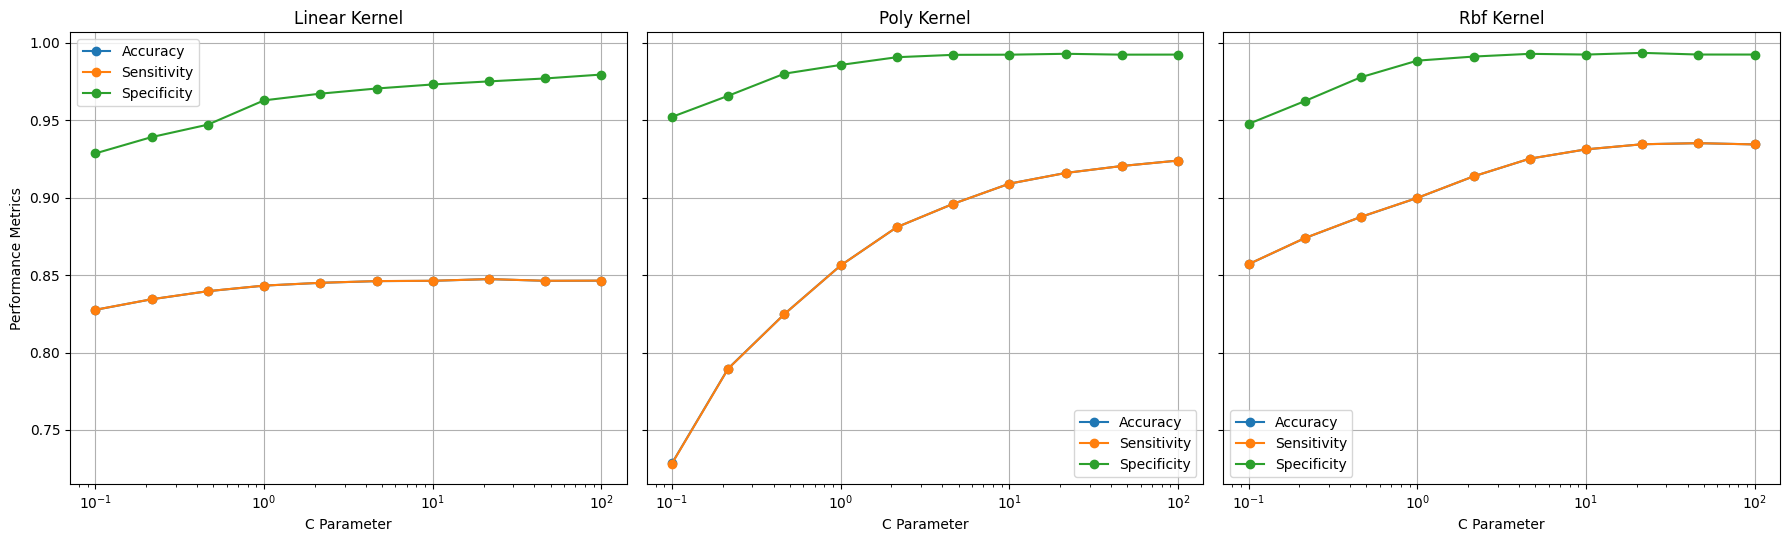

In [9]:
# Define figure with a 1x3 layout for each kernel
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# fig.suptitle("Performance Metrics vs C Parameter for Different Kernels", fontsize=16)

# Plot each kernel in a separate 1x3 layout
for i, kernel in enumerate(kernels):
    # Extract data for the current kernel
    c_values = results[kernel]["C"]
    accuracy_values = results[kernel]["average_accuracy"]
    sensitivity_values = results[kernel]["average_sensitivity"]
    specificity_values = results[kernel]["average_specificity"]

    # Plot all metrics for the current kernel in a single plot with 3 curves
    axes[i].plot(c_values, accuracy_values, marker='o', label="Accuracy")
    axes[i].plot(c_values, sensitivity_values, marker='o', label="Sensitivity")
    axes[i].plot(c_values, specificity_values, marker='o', label="Specificity")
    axes[i].set_xscale("log")
    axes[i].set_title(f"{kernel.capitalize()} Kernel")
    axes[i].set_xlabel("C Parameter")
    axes[i].grid(True)
    axes[i].legend()

# Set common y label
axes[0].set_ylabel("Performance Metrics")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
# Extract the best kernel and C value for each metric (accuracy, sensitivity, and specificity)

best_accuracy = {'kernel': None, 'C': None, 'value': 0}
best_sensitivity = {'kernel': None, 'C': None, 'value': 0}
best_specificity = {'kernel': None, 'C': None, 'value': 0}

for kernel in kernels:
    for i, C in enumerate(results[kernel]["C"]):
        # Check accuracy
        if results[kernel]["average_accuracy"][i] > best_accuracy['value']:
            best_accuracy.update(kernel=kernel, C=C, value=results[kernel]["average_accuracy"][i])

        # Check sensitivity
        if results[kernel]["average_sensitivity"][i] > best_sensitivity['value']:
            best_sensitivity.update(kernel=kernel, C=C, value=results[kernel]["average_sensitivity"][i])

        # Check specificity
        if results[kernel]["average_specificity"][i] > best_specificity['value']:
            best_specificity.update(kernel=kernel, C=C, value=results[kernel]["average_specificity"][i])

# Format the results into descriptive print statements
print("Optimal SVM Model Parameters for Each Performance Metric:\n")

print(f"1. Highest Accuracy:\n   Kernel: {best_accuracy['kernel'].capitalize()}"
      f", C: {best_accuracy['C']}, Accuracy: {best_accuracy['value']:.4f}")

print(f"2. Highest Sensitivity:\n   Kernel: {best_sensitivity['kernel'].capitalize()}"
      f", C: {best_sensitivity['C']}, Sensitivity: {best_sensitivity['value']:.4f}")

print(f"3. Highest Specificity:\n   Kernel: {best_specificity['kernel'].capitalize()}"
      f", C: {best_specificity['C']}, Specificity: {best_specificity['value']:.4f}")

Optimal SVM Model Parameters for Each Performance Metric:

1. Highest Accuracy:
   Kernel: Rbf, C: 46.41588833612778, Accuracy: 0.9351
2. Highest Sensitivity:
   Kernel: Rbf, C: 46.41588833612778, Sensitivity: 0.9351
3. Highest Specificity:
   Kernel: Rbf, C: 21.54434690031882, Specificity: 0.9934


In [11]:
# Create the SVM model with a cubic kernel
svm_optimal = SVC(kernel='rbf', C=21.54)

# Train the model
svm_optimal.fit(X_train, y_train)

SVC(C=21.54)

In [12]:
# Dataset and labels to make predictions and compare
model_pred = X_test
real_labels = y_test

# Optionally, evaluate the model on the "model_pred" data
y_pred = svm_optimal.predict(model_pred)

In [13]:
# Print the evaluation metrics
print("Accuracy on Test Data: ", accuracy_score(real_labels, y_pred))
print("Classification Report:\n", classification_report(real_labels, y_pred))

Accuracy on Test Data:  0.9387510008006406
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       500
         1.0       0.97      0.99      0.98       500
         2.0       0.95      0.98      0.97       500
         3.0       0.92      0.88      0.90       500
         4.0       0.96      0.95      0.95       498

    accuracy                           0.94      2498
   macro avg       0.94      0.94      0.94      2498
weighted avg       0.94      0.94      0.94      2498



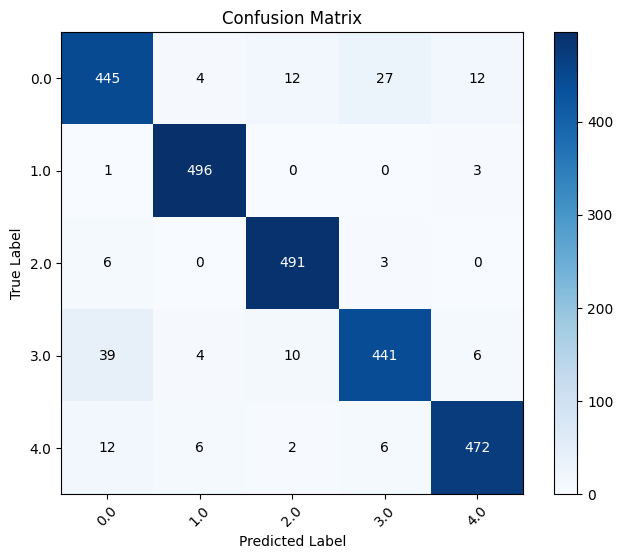

In [14]:
# Confusion Matrix
cm = confusion_matrix(real_labels, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display values inside the boxes
thresh = cm.max() / 2  # Threshold for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.grid(False)
plt.show()